In [232]:
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os


In [233]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [234]:
def isRect(contour):
    (x, y, w, h) = cv2.boundingRect(contour)
    a1 = cv2.contourArea(contour)
    a2 = w*h
    diff = abs(a1-a2)
    return (diff < (0.5 * a2))

In [235]:
def preRatioCheck(width, height, img):
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_area = img_width * img_height
    area = width*height
    min = 0.002*img_area
    max = 0.1*img_area

    ratioMin = 3
    ratioMax = 8

    ratio = float(width) / float(height)

    if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
        return False
    return True


def validateRatio(rect, img):
    (x, y), (width, height), rect_angle = rect
    if rect_angle >= 45:
        (width, height) = (height, width)
    if (height == 0 or width == 0):
        return False
    if not preRatioCheck(width, height, img):
        return False
    else:
        return True


In [236]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlurred = cv2.GaussianBlur(img, (7, 7), 0)
    sobelx = cv2.Sobel(imgBlurred, cv2.CV_8U, 1, 0, ksize=3)
    ret2, threshold_img = cv2.threshold(
        sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    element = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(26, 3))
    element2 = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(10, 3))
    morph_n_thresholded_img = threshold_img.copy()
    img_intermediate = morph_n_thresholded_img
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE,
                     kernel=element, dst=img_intermediate)
    cv2.morphologyEx(src=img_intermediate, op=cv2.MORPH_OPEN,
                     kernel=element2, dst=morph_n_thresholded_img)
    return morph_n_thresholded_img


In [237]:
def getLicensePlate(processed_img, img):
    contours, _ = cv2.findContours(processed_img, mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_NONE)
    imgs = []
    for contour in contours:
        min_rect = cv2.minAreaRect(contour)
        if validateRatio(min_rect, img) and isRect(contour):
            x, y, w, h = cv2.boundingRect(contour)
            after_validation_img = img[y:y + h, x:x + w]
            imgs.append(after_validation_img)
    return imgs


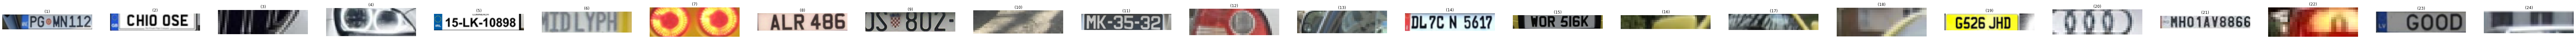

In [238]:
plates = []
for file in os.listdir(os.fsencode("closeCars")):
    filename = os.fsdecode(file)
    img = io.imread("./closeCars/" + filename)
    processed_img = preprocess(img)
    plates += getLicensePlate(processed_img, img)

show_images(plates)


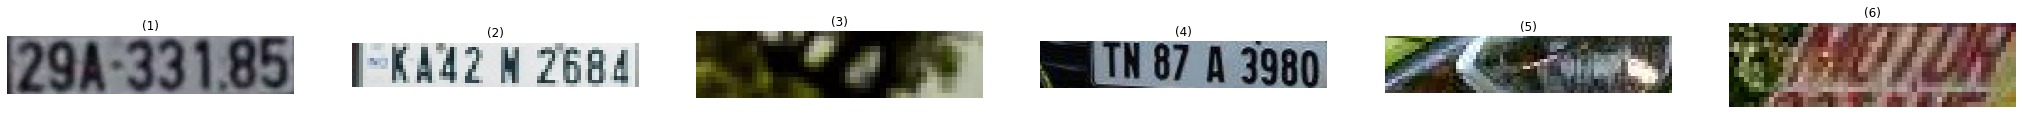

In [239]:
plates = []
for file in os.listdir(os.fsencode("farCars")):
    filename = os.fsdecode(file)
    img = io.imread("./farCars/" + filename)
    processed_img = preprocess(img)
    plates += getLicensePlate(processed_img, img)

show_images(plates[:10])